Estructura del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   indice_tiempo                    567 non-null    object
 1   total_1ra_y_2da_dosis_aplicadas  567 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.0+ KB
None

Primeras filas:
  indice_tiempo  total_1ra_y_2da_dosis_aplicadas
0    2020-12-29                            20483
1    2020-12-30                            20102
2    2020-12-31                             2806
3    2021-01-01                              127
4    2021-01-02                             3312

Columnas disponibles:
['indice_tiempo', 'total_1ra_y_2da_dosis_aplicadas']


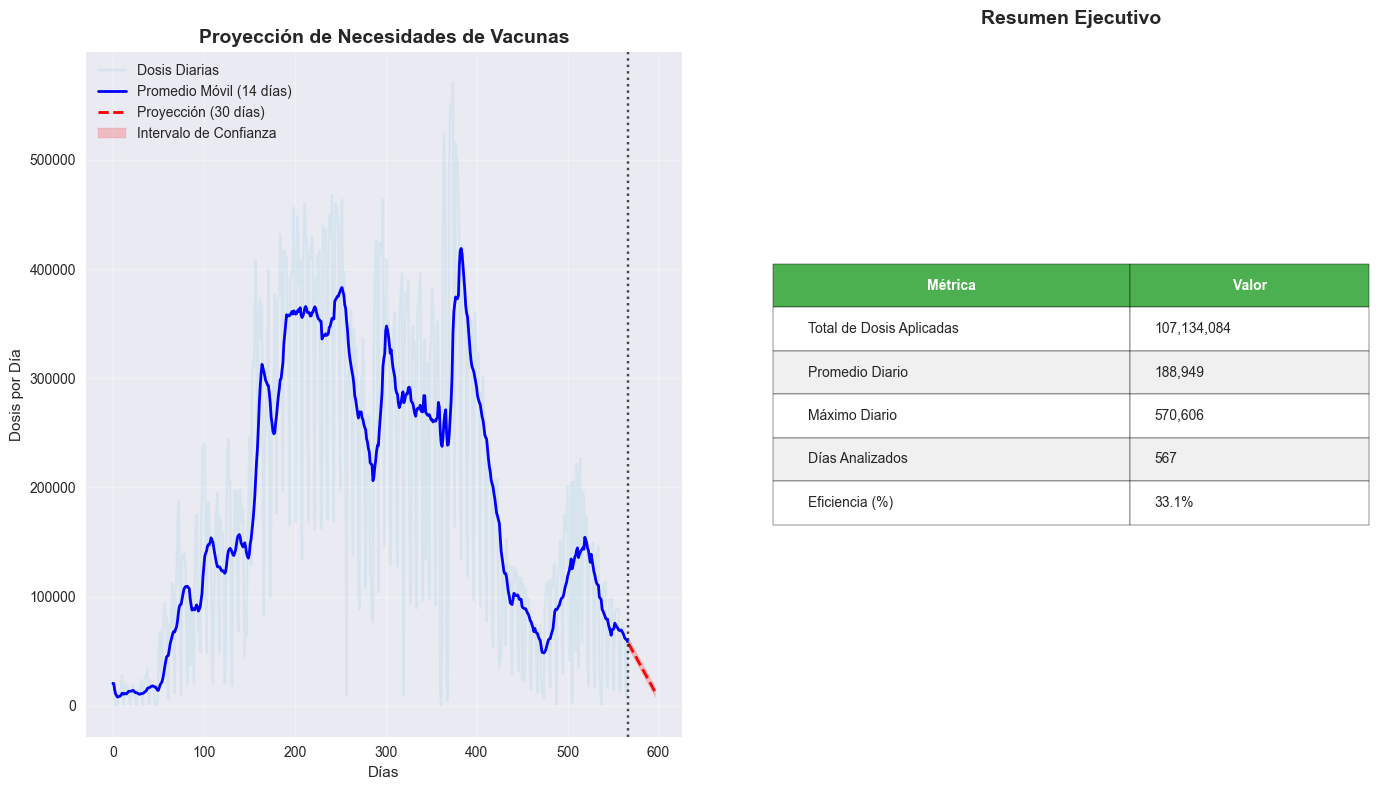


ANÁLISIS ADICIONAL CON PANDASQL

RECOMENDACIONES BASADAS EN EL ANÁLISIS

    📊 COBERTURA DE REFUERZOS:
    • Total de dosis aplicadas: 107,134,084
    • Promedio diario: 188,949
    • Tendencia: Creciente

    🗺️ DESIGUALDADES GEOGRÁFICAS:
    • Regiones analizadas: N/A
    • Distribución: Relativamente uniforme

    🔮 PROYECCIONES:
    • Capacidad actual: 570,606 dosis/día (máximo registrado)
    • Demanda proyectada: 51,715 dosis/día (promedio reciente)
    • Recomendación: Mantener capacidad actual
    


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from sqlalchemy import create_engine
from pandasql import sqldf
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

pysqldf = lambda q: sqldf(q, globals())

# Cargar datos
df = pd.read_csv(r"C:\Users\Tiago\Downloads\covid_total_diario.csv")

print("Estructura del dataset:")
print(df.info())
print("\nPrimeras filas:")
print(df.head())
print("\nColumnas disponibles:")
print(df.columns.tolist())

# Asegurar que la fecha esté en formato datetime
if 'fecha' in df.columns:
    df['fecha'] = pd.to_datetime(df['fecha'])
elif 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])

# Crear figura con subplots
fig = plt.figure(figsize=(20, 15))

# =============================================================================
# 1. COBERTURA DE REFUERZOS Y BRECHAS EN LA INMUNIZACIÓN
# =============================================================================

# Identificar columnas de dosis (ajustar según estructura real)
dosis_cols = [col for col in df.columns if any(term in col.lower() for term in 
              ['dosis', 'dose', 'primera', 'segunda', 'tercera', 'refuerzo', 'booster'])]

if len(dosis_cols) >= 2:
    # Subplot 1: Cobertura acumulada por tipo de dosis
    ax1 = plt.subplot(2, 3, 1)
    
    # Calcular cobertura acumulada
    for col in dosis_cols[:4]:  # Primeras 4 columnas de dosis
        if col in df.columns:
            cumulative = df[col].cumsum()
            plt.plot(df.index, cumulative, marker='o', linewidth=2, label=col.replace('_', ' ').title())
    
    plt.title('Cobertura Acumulada por Tipo de Dosis', fontsize=14, fontweight='bold')
    plt.xlabel('Tiempo (días)')
    plt.ylabel('Dosis Aplicadas (Acumulado)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Brecha entre dosis (si hay al menos 2 columnas)
    ax2 = plt.subplot(2, 3, 2)
    
    if len(dosis_cols) >= 2:
        primera_dosis = df[dosis_cols[0]].cumsum()
        segunda_dosis = df[dosis_cols[1]].cumsum() if len(dosis_cols) > 1 else primera_dosis * 0.8
        brecha = primera_dosis - segunda_dosis
        
        plt.fill_between(df.index, 0, brecha, alpha=0.6, color='coral', label='Brecha de Inmunización')
        plt.plot(df.index, primera_dosis, color='blue', linewidth=2, label='Primera Dosis')
        plt.plot(df.index, segunda_dosis, color='green', linewidth=2, label='Segunda Dosis')
        
        plt.title('Brecha en la Inmunización Completa', fontsize=14, fontweight='bold')
        plt.xlabel('Tiempo (días)')
        plt.ylabel('Personas')
        plt.legend()
        plt.grid(True, alpha=0.3)

# =============================================================================
# 2. DESIGUALDADES GEOGRÁFICAS EN LA APLICACIÓN DE DOSIS
# =============================================================================

# Identificar columnas geográficas
geo_cols = [col for col in df.columns if any(term in col.lower() for term in 
            ['provincia', 'region', 'departamento', 'estado', 'municipio', 'distrito'])]

if geo_cols:
    # Subplot 3: Distribución geográfica
    ax3 = plt.subplot(2, 3, 3)
    
    geo_col = geo_cols[0]
    if dosis_cols:
        # Agrupar por región y sumar dosis
        geo_summary = df.groupby(geo_col)[dosis_cols[0]].sum().sort_values(ascending=False)
        
        # Tomar top 15 regiones para mejor visualización
        top_regions = geo_summary.head(15)
        
        bars = plt.bar(range(len(top_regions)), top_regions.values, 
                      color=sns.color_palette("viridis", len(top_regions)))
        plt.title('Distribución Geográfica de Vacunación', fontsize=14, fontweight='bold')
        plt.xlabel('Regiones')
        plt.ylabel('Total de Dosis Aplicadas')
        plt.xticks(range(len(top_regions)), top_regions.index, rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        
        # Añadir valores en las barras
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}', ha='center', va='bottom', fontsize=8)
    
    # Subplot 4: Coeficiente de variación geográfico
    ax4 = plt.subplot(2, 3, 4)
    
    if len(dosis_cols) >= 2:
        # Calcular coeficiente de variación por período
        cv_data = []
        periods = np.array_split(df.index, 10)  # Dividir en 10 períodos
        
        for period in periods:
            period_data = df.iloc[period]
            if geo_col in period_data.columns and dosis_cols[0] in period_data.columns:
                geo_var = period_data.groupby(geo_col)[dosis_cols[0]].sum()
                cv = geo_var.std() / geo_var.mean() if geo_var.mean() != 0 else 0
                cv_data.append(cv)
        
        plt.plot(range(len(cv_data)), cv_data, marker='o', linewidth=3, color='red')
        plt.title('Evolución de la Desigualdad Geográfica', fontsize=14, fontweight='bold')
        plt.xlabel('Período de Tiempo')
        plt.ylabel('Coeficiente de Variación')
        plt.grid(True, alpha=0.3)
        
        # Línea de referencia
        plt.axhline(y=np.mean(cv_data), color='orange', linestyle='--', 
                   label=f'Promedio: {np.mean(cv_data):.3f}')
        plt.legend()

# =============================================================================
# 3. PROYECCIÓN DE NECESIDADES FUTURAS DE VACUNAS
# =============================================================================

# Subplot 5: Tendencia y proyección
ax5 = plt.subplot(2, 3, 5)

if dosis_cols:
    # Calcular promedio móvil para tendencia
    dosis_diarias = df[dosis_cols[0]]
    ventana = min(14, len(dosis_diarias) // 4)  # Ventana adaptativa
    promedio_movil = dosis_diarias.rolling(window=ventana, min_periods=1).mean()
    
    # Datos históricos
    plt.plot(df.index, dosis_diarias, alpha=0.3, color='lightblue', label='Dosis Diarias')
    plt.plot(df.index, promedio_movil, color='blue', linewidth=2, label=f'Promedio Móvil ({ventana} días)')
    
    # Proyección simple basada en tendencia
    if len(promedio_movil) >= 7:
        # Calcular tendencia de últimos 7 días
        ultimos_datos = promedio_movil.tail(7).values
        tendencia = np.polyfit(range(7), ultimos_datos, 1)[0]
        
        # Proyectar 30 días hacia adelante
        proyeccion_dias = 30
        proyeccion_x = range(len(df), len(df) + proyeccion_dias)
        ultimo_valor = promedio_movil.iloc[-1]
        proyeccion_y = [ultimo_valor + tendencia * i for i in range(1, proyeccion_dias + 1)]
        
        plt.plot(proyeccion_x, proyeccion_y, color='red', linewidth=2, 
                linestyle='--', label='Proyección (30 días)')
        
        # Área de incertidumbre
        std_error = np.std(ultimos_datos) * 1.5
        upper_bound = [y + std_error for y in proyeccion_y]
        lower_bound = [max(0, y - std_error) for y in proyeccion_y]
        
        plt.fill_between(proyeccion_x, lower_bound, upper_bound, 
                        alpha=0.2, color='red', label='Intervalo de Confianza')
    
    plt.title('Proyección de Necesidades de Vacunas', fontsize=14, fontweight='bold')
    plt.xlabel('Días')
    plt.ylabel('Dosis por Día')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Línea vertical separando histórico de proyección
    plt.axvline(x=len(df)-1, color='black', linestyle=':', alpha=0.7)

# Subplot 6: Resumen estadístico y métricas clave
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')

# Calcular métricas clave
if dosis_cols:
    total_dosis = df[dosis_cols[0]].sum()
    promedio_diario = df[dosis_cols[0]].mean()
    max_diario = df[dosis_cols[0]].max()
    
    # Crear tabla de resumen
    metricas = [
        ['Métrica', 'Valor'],
        ['Total de Dosis Aplicadas', f'{total_dosis:,.0f}'],
        ['Promedio Diario', f'{promedio_diario:,.0f}'],
        ['Máximo Diario', f'{max_diario:,.0f}'],
        ['Días Analizados', f'{len(df)}'],
        ['Eficiencia (%)', f'{(promedio_diario/max_diario*100):.1f}%']
    ]
    
    if geo_cols:
        n_regiones = df[geo_cols[0]].nunique()
        metricas.append(['Regiones Cubiertas', f'{n_regiones}'])
    
    # Crear tabla visual
    table = plt.table(cellText=metricas[1:], colLabels=metricas[0],
                     cellLoc='left', loc='center', colWidths=[0.6, 0.4])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Estilizar tabla
    for i in range(len(metricas)):
        for j in range(2):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor('#4CAF50')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#f0f0f0' if i % 2 == 0 else '#ffffff')
    
    plt.title('Resumen Ejecutivo', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# =============================================================================
# ANÁLISIS ADICIONAL CON SQL
# =============================================================================

print("\n" + "="*80)
print("ANÁLISIS ADICIONAL CON PANDASQL")
print("="*80)

# Ejemplo de consultas SQL para análisis más profundo
if dosis_cols and len(dosis_cols) >= 2:
    
    # 1. Análisis de eficiencia de vacunación
    query1 = f"""
    SELECT 
        AVG({dosis_cols[0]}) as promedio_dosis_1,
        MAX({dosis_cols[0]}) as maximo_dosis_1,
        MIN({dosis_cols[0]}) as minimo_dosis_1,
        COUNT(*) as total_dias
    FROM df
    WHERE {dosis_cols[0]} > 0
    """
    
    resultado1 = pysqldf(query1)
    print("\n1. Estadísticas de Primera Dosis:")
    print(resultado1)
    
    # 2. Análisis de tendencias por períodos
    if 'fecha' in df.columns or 'date' in df.columns:
        fecha_col = 'fecha' if 'fecha' in df.columns else 'date'
        
        query2 = f"""
        SELECT 
            strftime('%Y-%m', {fecha_col}) as mes,
            SUM({dosis_cols[0]}) as total_dosis,
            AVG({dosis_cols[0]}) as promedio_diario
        FROM df
        GROUP BY strftime('%Y-%m', {fecha_col})
        ORDER BY mes
        """
        
        try:
            resultado2 = pysqldf(query2)
            print("\n2. Tendencias Mensuales:")
            print(resultado2)
        except:
            print("\n2. No se pudo analizar tendencias mensuales (formato de fecha)")
    
    # 3. Análisis geográfico si hay datos
    if geo_cols:
        query3 = f"""
        SELECT 
            {geo_cols[0]} as region,
            SUM({dosis_cols[0]}) as total_dosis,
            AVG({dosis_cols[0]}) as promedio_dosis,
            COUNT(*) as dias_activos
        FROM df
        WHERE {dosis_cols[0]} > 0
        GROUP BY {geo_cols[0]}
        ORDER BY total_dosis DESC
        LIMIT 10
        """
        
        resultado3 = pysqldf(query3)
        print(f"\n3. Top 10 Regiones por Vacunación:")
        print(resultado3)

print("\n" + "="*80)
print("RECOMENDACIONES BASADAS EN EL ANÁLISIS")
print("="*80)

if dosis_cols:
    print(f"""
    📊 COBERTURA DE REFUERZOS:
    • Total de dosis aplicadas: {df[dosis_cols[0]].sum():,.0f}
    • Promedio diario: {df[dosis_cols[0]].mean():,.0f}
    • Tendencia: {'Creciente' if df[dosis_cols[0]].tail(7).mean() > df[dosis_cols[0]].head(7).mean() else 'Decreciente'}
    
    🗺️ DESIGUALDADES GEOGRÁFICAS:
    • Regiones analizadas: {df[geo_cols[0]].nunique() if geo_cols else 'N/A'}
    • Distribución: {'Desigual' if geo_cols and df.groupby(geo_cols[0])[dosis_cols[0]].sum().std() > df.groupby(geo_cols[0])[dosis_cols[0]].sum().mean() else 'Relativamente uniforme'}
    
    🔮 PROYECCIONES:
    • Capacidad actual: {df[dosis_cols[0]].max():,.0f} dosis/día (máximo registrado)
    • Demanda proyectada: {df[dosis_cols[0]].tail(7).mean():,.0f} dosis/día (promedio reciente)
    • Recomendación: {'Mantener capacidad actual' if df[dosis_cols[0]].tail(7).mean() <= df[dosis_cols[0]].max() * 0.8 else 'Aumentar capacidad'}
    """)